# Determining the difference between sampled data within similar time ranges

## Goal of project: 
-  Find different ways to compare time series. 
-  Quantify the similarity or dis-similarity of two (or more) time series.

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

import math

import statistics
from scipy import stats

from scipy.fftpack import fft, ifft

from scipy import interpolate

### A few select curves to compare

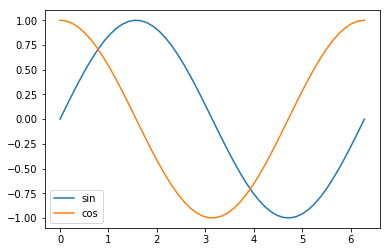

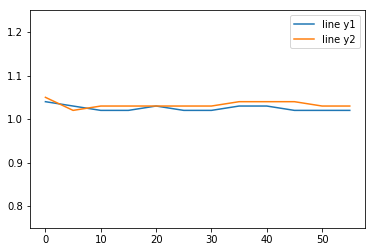

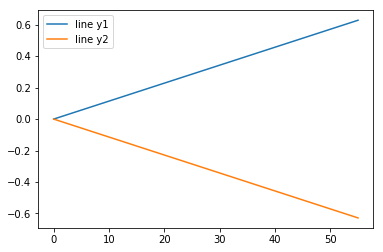

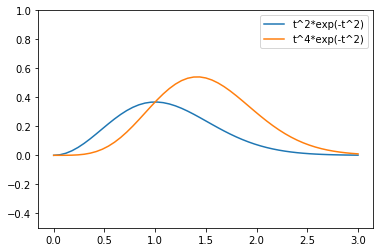

In [18]:
# Comparing sin and cos
x = np.linspace(0, 2 * np.pi)
sin = np.sin(x)
cos = np.cos(x)

fig, ax = plt.subplots()
ax.plot(x, sin, label="sin")
ax.plot(x, cos, label="cos")
ax.legend()
plt.show()

# Comparing two approximately flat lines
line_x = np.array([0,5,10,15,20,25,30,35,40,45,50,55])
line_y1 = np.array([1.04,1.03,1.02,1.02,1.03,1.02,1.02,1.03,1.03,1.02,1.02,1.02])
line_y2 = np.array([1.05,1.02,1.03,1.03,1.03,1.03,1.03,1.04,1.04,1.04,1.03,1.03])

fig, ax = plt.subplots()
ax.plot(line_x, line_y1, label="line y1")
ax.plot(line_x, line_y2, label="line y2")
plt.ylim(top=1.25, bottom=0.75) 
ax.legend()
plt.show()

# Comparing two flat lines
linear_x = np.linspace(0, 55)
linear_y1 = x * 0.1
linear_y2 = x * - 0.1

fig, ax = plt.subplots()
ax.plot(linear_x, linear_y1, label="line y1")
ax.plot(linear_x, linear_y2, label="line y2")
ax.legend()
plt.show()

# Comparing two similar curves that are concave down
def f1(t):
    return t**2*np.exp(-t**2)

def f2(t):
    return t**2*f1(t)

t = np.linspace(0, 3, 51) # 51 points between 0 and 3
y1 = f1(t) 
y2 = f2(t) 

fig, ax = plt.subplots()
ax.plot(t, y1, label='t^2*exp(-t^2)')
ax.plot(t, y2, label='t^4*exp(-t^2)')
# plt.ylim(top=-0.5, bottom=0.7) 
plt.ylim(top=1, bottom=-.5) 
ax.legend()
plt.show()

## Diffing areas (integrals)

In [19]:
# Comparing sin and cos integrals
sin_int = integrate.trapz(sin, x)
cos_int = integrate.trapz(cos, x)

print (sin_int - cos_int)

7.806255641895632e-17


In [20]:
# Comparing ~flat lines
linear_int = integrate.trapz(linear_y1, linear_x)
linear2_int = integrate.trapz(linear_y2, linear_x)

print (abs(linear_int - linear2_int))

34.55751918948773


In [21]:
# Comparing concave down
conc_int = integrate.trapz(y1, t)
conc2_int = integrate.trapz(y2, t)

print (abs(conc_int - conc2_int))

0.21978103954325745


## Diffing ~straight-lines (statistics)

**Compute statistics for two sets of measurements:**

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

slope : slope of the regression line

intercept : intercept of the regression line

r-value : correlation coefficient

p-value : two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero

stderr : Standard error of the estimate

The closer that the absolute value of the correlation coefficient (r value) is to one, the better the data are described by a linear equation. 
The dataset is perfectly aligned if r = 1 or r = -1. Datasets with r values close to zero show little 
to no straight-line relationship.

    r-value > 0.99: implies that the curves are virtually identical

    r-value > 0.95: suggests very high similarity

    0.67 < r-value < 0.95: indicates that the curves have high similarity

    0.33 < r-value < 0.67: some (moderate) similarity

    0.05 < r-value < 0.33: the curves are not very similar

    r-value < 0.05: the curves do not have any similarity at all

Note that when using pandas, to compute the correlation coefficient, see: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

In [22]:
# Comparing sin and cos
slope, intercept, r_value, p_value, std_err = stats.linregress(sin, cos)
print ('Sin vs cos:', '\nr value:', r_value, '\np-value:', p_value) # As expected, these curves are not linear, and thus show r values close to zero

Sin vs cos: 
r value: 6.665285165231957e-18 
p-value: 1.0


In [23]:
# Comparing ~flat lines
slope, intercept, r_value, p_value, std_err = stats.linregress(line_y1, line_y2)
print ('Straight lines:', '\nr value:', r_value, '\np-value:', p_value)

##### x values aren't consirdered here, so this may be incorrect. Fix

Straight lines: 
r value: 0.5196152422706631 
p-value: 0.08336922304872832


In [24]:
# Comparing concave down
slope, intercept, r_value, p_value, std_err = stats.linregress(y1, y2)
print ('Concave down:', '\nr value:', r_value, '\np-value:', p_value)

##### x values aren't consirdered here, so this may be incorrect. Fix

Concave down: 
r value: 0.6543054162699397 
p-value: 1.9149678083855617e-07


In [25]:
# Comparing straight lines that have different slopes
slope, intercept, r_value, p_value, std_err = stats.linregress(linear_y1, linear_y2)
print ('Straight lines with different slopes:', '\nr value:', r_value, '\np-value:', p_value)

Straight lines with different slopes: 
r value: -1.0 
p-value: 0.0


## Measure the distance and area between two curves

Distance: 
Minimum distance between curves:  0.49
Maximum distance between curves:  0.86
Mean distance between curves:  0.71

Area: 
Area between curves:  4.76

Statistics: 
r value: 0.000 
p-value: 1.000

The curves do not have any similarity at all.


/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


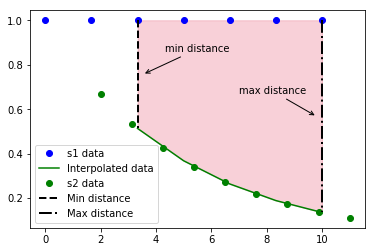

In [32]:
def compare_curves(xs1, ys1, xs2, ys2):
    """
    Parameters:
    xs1: input array of x values from sampled data 
    ys1: input array of y values of sampled data
    xs2: input a second array of x values of sampled data
    ys2: input a second array of y values of sampled data
    
    NOTE: the x1 and y1 values must have the same shape. And the
    x2 and y2 values must have the same shape.
    
    Finds the overlapping x-values and analyzes that region between two curves.
    Return the absolute minimum, maximum, and mean vertical distances between two curves.
    Return the absolute area between two curves.
    A plot of the curves is provided with the area shaded.
    """

    # Determine the overlapping x- values in order to align the values between the two curves to compare them
    xs1_min = min(xs1)
    xs1_max = max(xs1)
    xs2_min = min(xs2)
    xs2_max =  max(xs2)
    xs_overlap_min = max(xs1_min, xs2_min)
    xs_overlap_max = min(xs1_max, xs2_max)
    # print (f"Overlapping x: [{xs_overlap_min}, {xs_overlap_max}]") # The min and max overlap values, provides two overall values for the min and max overlap range between the two curves
    
    xs1_overlap_where = np.where((xs1 >= xs_overlap_min) & (xs1 <= xs_overlap_max)) # x values >= the min of both curves and x values <= the max of both curves
    xs1_overlap = xs1[xs1_overlap_where] # xs1 overlap values, these are the points along the xs1 curve within the overlap range
    
    # Interpolate master curve
    f2 = interpolate.interp1d(xs2, ys2, kind='cubic')
    ys2_interp_overlap = f2(xs1_overlap) # y values of the interpolated line at the points of xs1_overlap range
    
    # Compute vertical difference in y values between the y values of ys1 within the xs1 overlap range and the y values of the interpolated line (ys2) at the ys1 points of xs1 overlap range
    diff_overlap = abs(ys1[xs1_overlap_where] - ys2_interp_overlap) # y values of ys1 within the overlap range minus the y values of the interpolated line at the ys1 points of overlap range
    # print ('diff overlap: ', diff_overlap)
    
    # Compute Euclidean distance between the above two curves (same as above vertical difference calculation because the x-values here are the same now)
    Euc_dist = np.sqrt((xs1_overlap - xs1_overlap)**2 + (ys1[xs1_overlap_where] - ys2_interp_overlap)**2) 
    
    # Compute min, max, mean values between curves
    diff_overlap_min = min(diff_overlap)
    diff_overlap_max = max(diff_overlap)
    print ('Distance:','\nMinimum distance between curves: ', round(diff_overlap_min, 2))
    print ('Maximum distance between curves: ', round(diff_overlap_max, 2))
    print ('Mean distance between curves: ', round(np.mean(diff_overlap), 2))
    
    # Determine the index of both the min and max distances between two curves are within y_distance
    y_min = min(diff_overlap)
    y_max = max(diff_overlap)
    y_diff_overlap_index = [0]
    index = 0
    for i in diff_overlap:
        index = index + 1
        y_diff_overlap_index.append(index)
        if i == y_min:
            y_dist_index_min = index - 1 # Index of where the minimum distance between the curves is located within y_distance
        elif i == y_max:
            y_dist_index_max = index - 1 # Index of where the maximum distance between the curves is located within y_distance
    
    x_value_min = []
    x_value_max = []
    for i in range(2):    
        x_value_min.append(xs1_overlap[y_dist_index_min]) # x value where the minimum between the two curves is located, appending it twice in order to plot the min location between curves
        x_value_max.append(xs1_overlap[y_dist_index_max]) # x value where the maximum between the two curves is located, appending it twice in order to plot the max location between curves
    
    # Get endpoints at minimum and maximum distances between curves, to annotate plot
    diff_overlap_min_y = [] # Two y-axis end points where the minimum between the two curves is located
    diff_overlap_min_y.append(ys1[xs1_overlap_where][y_dist_index_min])
    diff_overlap_min_y.append(ys2_interp_overlap[y_dist_index_min])
    diff_overlap_min_y_middle = ((ys1[xs1_overlap_where][y_dist_index_min]) + (ys2_interp_overlap[y_dist_index_min]))/2 # Location of where to annotate an arrow along the y-axis
    diff_overlap_max_y = [] # Two y-axis end points where the maximum between the two curves is located
    diff_overlap_max_y.append(ys1[xs1_overlap_where][y_dist_index_max])
    diff_overlap_max_y.append(ys2_interp_overlap[y_dist_index_max])
    diff_overlap_max_y_middle = ((ys1[xs1_overlap_where][y_dist_index_max]) + (ys2_interp_overlap[y_dist_index_max]))/2 # Location of where to annotate an arrow along the y-axis
    
    # Compute the area in between the curves 
    curves_int1 = integrate.trapz(ys1[xs1_overlap_where], xs1_overlap)
    curves_int2 = integrate.trapz(ys2_interp_overlap, xs1_overlap)
    integrated_diff = abs(curves_int1 - curves_int2)
    print ('\nArea:', '\nArea between curves: ', round(integrated_diff, 2))
    
    # Calculate statistics between the curves, within the overlap range
    slope, intercept, r_value, p_value, std_err = stats.linregress(ys1[xs1_overlap_where], ys2_interp_overlap)
    print ('\nStatistics:', '\nr value:', '{:<0.3f}'.format(r_value), '\np-value:', '{:<0.3f}'.format(p_value))
    
    # Print the similarity of two curves, based on the obtained r value
    if r_value > 0.99:
        print ('\nThe curves are virtually identical.')
    elif r_value > 0.95:
        print ('\nThe curves have very high similarity.')
    elif r_value > 0.67 and r_value < 0.95:
        print ('\nThe curves have high similarity.')
    elif r_value > 0.33 and r_value < 0.67:
        print ('\nThe curves have some (moderate) similarity.')
    elif r_value > 0.05 and r_value < 0.33:
        print ('\nThe curves are not very similar.')
    elif r_value < 0.05:
        print ('\nThe curves do not have any similarity at all.')
    
    # Plot the curves
    plt.plot(xs1, ys1, 'bo', label='s1 data')
    plt.plot(xs1_overlap, ys2_interp_overlap, 'g-', label='Interpolated data')
    plt.plot(xs2, ys2, 'go', label='s2 data')
    plt.plot(x_value_min, diff_overlap_min_y, 'k--', linewidth=2, label='Min distance')
    plt.plot(x_value_max, diff_overlap_max_y, 'k-.', linewidth=2, label='Max distance')
    plt.legend(loc='best')
    plt.annotate('min distance', xy=((x_value_min[0]+.2), (diff_overlap_min_y_middle)), xytext=((x_value_min[0] + 1), (diff_overlap_min_y_middle+.1)),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.annotate('max distance', xy=((x_value_max[0]-.2), (diff_overlap_max_y_middle)), xytext=((x_value_max[0] - 3), (diff_overlap_max_y_middle+.1)),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.fill_between(xs1_overlap, (ys2_interp_overlap), ys1[xs1_overlap_where], color="crimson", alpha=0.2) # The area is shaded between the curves
    #plt.show()
    plt.savefig("straight_vs_curved.png", dpi=150)
  

xs1 = np.linspace(0, 10, 7)
xs2 = np.linspace(2, 11, 9)
ys1 = np.ones_like(xs1)
ys2 = np.exp(-xs2/5.0)
compare_curves(xs1, ys1, xs2, ys2)

Distance: 
Minimum distance between curves:  0.11
Maximum distance between curves:  0.36
Mean distance between curves:  0.22

Area: 
Area between curves:  1.64

Statistics: 
r value: 0.995 
p-value: 0.000

The curves are virtually identical.


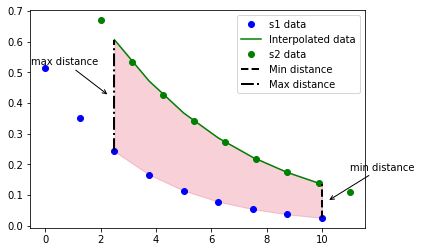

In [31]:
# Alternate curves
xs1 = np.linspace(0, 10, 9)
xs2 = np.linspace(2, 11, 9)
ys1 = np.exp(-xs2/3.0)
ys2 = np.exp(-xs2/5.0)
compare_curves(xs1, ys1, xs2, ys2)


Distance: 
Minimum distance between curves:  0.02
Maximum distance between curves:  1.35
Mean distance between curves:  0.71

Area: 
Area between curves:  0.58

Statistics: 
r value: -0.815 
p-value: 0.000

The curves do not have any similarity at all.


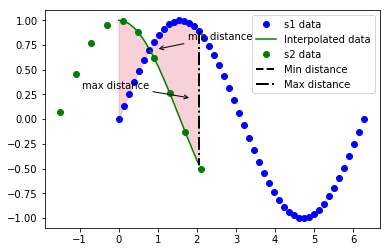

In [29]:
x_values = np.linspace(0, 2 * np.pi)
sin_values = np.sin(x_values)
x2_values = np.arange(-1.5, 2.5, 0.4)
cos_values = np.cos(x2_values)
compare_curves(x_values, sin_values, x2_values, cos_values)

## Measure the shape between two curves

In [ ]:
# Compare the number of knots, and inflection points.  Compare the spline methods for estimating the curves and compare the nodes.
# Calculate curvature as a function of arc length for each curve and see how they compare
# Compute discreet derivatives along each curve and compare the two curves
# Check into dynamic time warping
# Connect a finite number of points on the curve using line segments to create a polygonal path and compare the slopes of multiple approximated linear segments

## Goodness-of-fit tests

### *Kolmogorov-Smirnov test*
https://projecteuclid.org/download/pdf_1/euclid.aoms/1177706788

https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm

The Kolmogorov-Smirnov test can be used to determine if two datasets differ significantly. There are two Kolmogorov-Smirnov tests:
-  The *one sample Kolmogorov-Smirnov test* is for testing if a variable follows a given distribution within a population. This given distribution is usually, but not always, the normal distribution, and is sometimes called the “Kolmogorov-Smirnov normality test”
-  The *independent samples Kolmogorov-Smirnov test* is for testing if a variable has identical distributions in two populations.

Note that the k-s test shown in the code below returns the D statistic (KS statistic) and a p-value corresponding to the D. 

P-values report if the numbers differ significantly. When discussing a p-value, we are referring to the area under the curve of a distribution. The p-value is a number between 0 and 1 and interpreted in the following way:

    p-value ≤ 0.05 - indicates strong evidence against the null hypothesis. So, reject the null hypothesis

    p-value > 0.05 - indicates weak evidence against the null hypothesis. Do not reject the null hypothesis

    p-values very close to 0.05 are considered to be marginal (they could go either way)

The D is the absolute max distance between the cumulative distribution function's of the two samples. The closer the D is to zero, the more likely it is that the two samples were drawn from the same distribution.  

In [ ]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples, use: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html
# Note that the test uses the two-sided asymptotic Kolmogorov-Smirnov distribution

KS_sin_cos = stats.ks_2samp(sin, cos)
KS_straight = stats.ks_2samp(line_y1, line_y2)
KS_conc_down = stats.ks_2samp(y1, y2)
print ('Sin vs cos: ', '\nD statistic:', KS_sin_cos[0], '\nP-value:', KS_sin_cos[1])
print ('\nStraight lines: ', '\nD statistic:', KS_straight[0], '\nP-value:', KS_straight[1])
print ('\nConcave down: ', '\nD statistic:', KS_conc_down[0], '\nP-value:', KS_conc_down[1])




It appears that what I had planned on doing with this project has been done here: https://pypi.org/project/similaritymeasures/